In [57]:
# Importando as bibliotecas necessárias
import pandas as pd
import os
import kagglehub
import shutil
import requests
import gzip
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats

# Etapa 3

### Transformação Tidy

In [17]:
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

# 1. Leitura do arquivo
df_streaming_completo = pd.read_csv(output_csv_file)

# CORREÇÃO 1: Remover colunas 'Unnamed' geradas erroneamente no passado
df_streaming_completo = df_streaming_completo.loc[:, ~df_streaming_completo.columns.str.contains('^Unnamed')]

# CORREÇÃO 2: Limpeza prévia de colunas de Gênero antigas
# Isso impede que gere Genre_Action.1, Genre_Action.2, etc.
cols_to_drop = [col for col in df_streaming_completo.columns if col.startswith('Genre_')]
if cols_to_drop:
    print(f"Removendo {len(cols_to_drop)} colunas de gêneros antigas para recriá-las...")
    df_streaming_completo = df_streaming_completo.drop(columns=cols_to_drop)

# Tratamento de nulos
df_streaming_completo['genres_processed'] = df_streaming_completo['genres_processed'].fillna('Unknown')

# Criação dos Dummies
genre_dummies = df_streaming_completo['genres_processed'].str.get_dummies(sep=', ')
genre_dummies = genre_dummies.add_prefix('Genre_')

# Concatenação
df_streaming_completo = pd.concat([df_streaming_completo, genre_dummies], axis=1)

# CORREÇÃO 3: Salvar com index=False para não gerar coluna Unnamed na próxima leitura
df_streaming_completo.to_csv(output_csv_file, index=False)

print("✅ Gêneros processados e salvos.")
df_streaming_completo.info()

✅ Gêneros processados e salvos.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14436 entries, 0 to 14435
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   show_id                     14436 non-null  object 
 1   type                        14436 non-null  object 
 2   title                       14436 non-null  object 
 3   director                    10866 non-null  object 
 4   cast                        13287 non-null  object 
 5   country                     7986 non-null   object 
 6   date_added                  8017 non-null   object 
 7   release_year                14436 non-null  int64  
 8   rating                      14225 non-null  object 
 9   duration                    14436 non-null  object 
 10  listed_in                   14436 non-null  object 
 11  description                 14436 non-null  object 
 12  genres_processed            14436 non-null  object 
 13 

In [18]:
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')
df_streaming = pd.read_csv(output_csv_file)

# 2. Definir os intervalos (bins) - IGUAL
bins = [0, 2, 4, 6, 8, 10]

# 0: Muito Ruim (0-2)
# 1: Ruim (2.1-4)
# 2: Médio (4.1-6)
# 3: Bom (6.1-8)
# 4: Excelente (8.1-10)
labels_numericos = [0, 1, 2, 3, 4]

# 3. Criar a coluna 'target' (Alvo)
# O pd.cut agora vai colocar os números 0, 1, 2, 3 ou 4
df_streaming['target'] = pd.cut(df_streaming['imdb_rating_concatenada'], 
                                bins=bins, 
                                labels=labels_numericos, 
                                include_lowest=True)

# Garantir que é do tipo inteiro (às vezes o pandas deixa como 'category')
df_streaming['target'] = df_streaming['target'].astype(int)

# 4. Visualizar
print("Exemplo dos dados preparados para o modelo:")
print(df_streaming[['title', 'imdb_rating_concatenada', 'target']].head(10))

# 5. Ver a contagem (para checar se as classes estão desbalanceadas)
print("\nContagem de classes (0 a 4):")
print(df_streaming['target'].value_counts().sort_index())

mapa_classes = {
    0: '0-2 (Muito Ruim)',
    1: '2.1-4 (Ruim)',
    2: '4.1-6 (Médio)',
    3: '6.1-8 (Bom)',
    4: '8.1-10 (Excelente)'
}
print("\nLegenda das Classes:", mapa_classes)

df_streaming.to_csv(output_csv_file, index=False)

Exemplo dos dados preparados para o modelo:
                       title  imdb_rating_concatenada  target
0                      54321                      5.8       2
1                     Serena                      5.5       2
2              A Secret Love                      7.8       3
3             Cover Versions                      5.5       2
4                       Narc                      7.1       3
5  Survivors Guide to Prison                      7.1       3
6                  Duplicate                      5.6       2
7         Road To High & Low                      6.5       3
8          Dennis the Menace                      5.7       2
9                      Ferry                      7.0       3

Contagem de classes (0 a 4):
target
0      31
1     765
2    4797
3    8117
4     726
Name: count, dtype: int64

Legenda das Classes: {0: '0-2 (Muito Ruim)', 1: '2.1-4 (Ruim)', 2: '4.1-6 (Médio)', 3: '6.1-8 (Bom)', 4: '8.1-10 (Excelente)'}


In [19]:
# --- Configuração de Caminhos ---
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

print(f"Processando coluna 'rating' no arquivo: {output_csv_file}")

# 1. Carrega o DataFrame
try:
    df = pd.read_csv(output_csv_file)
except FileNotFoundError:
    print(f"ERRO: Arquivo '{output_csv_file}' não encontrado.")
    exit()

# 2. Limpeza de segurança (Remove Unnamed)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# 3. Idempotência: Remove colunas criadas anteriormente por este script
# Se rodar de novo, apagamos a 'rating_target' antes de recriar
if 'rating_target' in df.columns:
    print("Removendo coluna 'rating_target' antiga para recálculo...")
    df = df.drop(columns=['rating_target'])

# Verifica se a coluna original 'rating' existe
if 'rating' in df.columns:
    
    # 4. Definição dos Dicionários e Listas (Baseado no seu código)
    rating_ordem = {
        'TV-Y': 1,      # Livre para todas as idades
        'G': 1,         # Livre
        'TV-G': 1,      # Livre
        'ALL': 1,       # Geral
        'ALL_AGES': 1,  # Geral
        'PG': 2,        # Orientação dos pais
        'TV-PG': 2,     # Orientação dos pais
        '7+': 3,        # Maiores de 7
        'TV-Y7': 3,     # Maiores de 7
        'TV-Y7-FV': 3,  # Maiores de 7 (Fantasy Violence)
        'PG-13': 4,     # Maiores de 13
        '13+': 4,       # Maiores de 13
        'TV-14': 5,     # Maiores de 14
        '16+': 5,       # Maiores de 16
        '16': 5,        # Maiores de 16
        'AGES_16+': 5,  # Maiores de 16
        'AGES_16_': 5,  # Maiores de 16
        'R': 6,         # Maiores de 17 (Requer companhia de adulto)
        'TV-MA': 6,     # Maiores de 18
        'NC-17': 6,     # Maiores de 18
        '18+': 6,       # Maiores de 18
        'AGES_18+': 6,  # Maiores de 18
        'AGES_18_': 6   # Maiores de 18
    }

    ratings_para_remover = ['NOT_RATE', 'UNRATED', 'TV-NR', 'NR', 'UR', '74 min', '84 min', '66 min', 'Unknown']

    print("Aplicando filtros e mapeamento de ratings...")

    # 5. Filtragem
    # Remove linhas que tenham ratings indesejados ou inválidos
    # Apenas mantemos o que NÃO ESTÁ na lista de remover
    df = df[~df['rating'].isin(ratings_para_remover)]

    # 6. Mapeamento
    # Cria a nova coluna numérica baseada no dicionário
    df['rating_target'] = df['rating'].map(rating_ordem)

    # 7. Limpeza de Nulos gerados pelo Mapeamento
    # Se algum rating não estava no dicionário, ele virou NaN. Vamos remover essas linhas para não sujar o dataset.
    linhas_antes = len(df)
    df = df.dropna(subset=['rating_target'])
    linhas_depois = len(df)
    
    if linhas_antes != linhas_depois:
        print(f"AVISO: {linhas_antes - linhas_depois} linhas foram removidas pois tinham ratings fora do padrão mapeado.")

    # Converte para Inteiro (pois o map pode gerar float se houver NaN temporário)
    df['rating_target'] = df['rating_target'].astype(int)

    # 8. Remoção da Coluna Original
    print("Removendo a coluna original 'rating' (texto)...")
    df = df.drop(columns=['rating'])

else:
    print("AVISO: A coluna 'rating' não foi encontrada (provavelmente já foi processada).")

# 9. Salvar
df.to_csv(output_csv_file, index=False)

print("✅ Processo concluído! Coluna 'rating_target' criada (1 a 6).")

# Visualização final
if 'rating_target' in df.columns:
    print("\nContagem dos novos grupos de rating:")
    print(df['rating_target'].value_counts().sort_index())

Processando coluna 'rating' no arquivo: ../data\filmes_series_imdb.csv
Aplicando filtros e mapeamento de ratings...
AVISO: 211 linhas foram removidas pois tinham ratings fora do padrão mapeado.
Removendo a coluna original 'rating' (texto)...
✅ Processo concluído! Coluna 'rating_target' criada (1 a 6).

Contagem dos novos grupos de rating:
rating_target
1    1247
2    1636
3     529
4    2377
5    3109
6    5084
Name: count, dtype: int64


In [20]:
def remover_nulos_por_coluna(caminho_csv, nomes_colunas):
    """
    Lê um arquivo CSV e retorna um DataFrame sem as linhas
    onde a 'nomes_colunas' especificada está em branco (NaN ou string vazia).
    """
    try:
        # 1. Lê o arquivo CSV
        df = pd.read_csv(caminho_csv)
    except FileNotFoundError:
        print(f"ERRO: O arquivo '{caminho_csv}' não foi encontrado.")
        return None
    except Exception as e:
        print(f"ERRO ao ler o arquivo: {e}")
        return None

    # 2. Verifica se a coluna existe no DataFrame
    colunas_faltando = [col for col in nomes_colunas if col not in df.columns]
    
    if colunas_faltando:
        print(f"ERRO: As seguintes colunas não foram encontradas: {colunas_faltando}")
        print(f"Colunas disponíveis: {df.columns.to_list()}")
        return None

    # 3. Remove as linhas onde a coluna é Nula (NaN, pd.NA, etc.)
    df_limpo = df.dropna(subset=nomes_colunas)

    # 5. Devolve o DataFrame limpo
    return df_limpo

#Teste
df = remover_nulos_por_coluna(output_csv_file, ['country'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7895 entries, 2 to 13981
Data columns (total 81 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   show_id                     7895 non-null   object 
 1   type                        7895 non-null   object 
 2   title                       7895 non-null   object 
 3   director                    5723 non-null   object 
 4   cast                        7303 non-null   object 
 5   country                     7895 non-null   object 
 6   date_added                  7328 non-null   object 
 7   release_year                7895 non-null   int64  
 8   duration                    7895 non-null   object 
 9   listed_in                   7895 non-null   object 
 10  description                 7895 non-null   object 
 11  genres_processed            7895 non-null   object 
 12  streaming                   7895 non-null   object 
 13  imdb_rating_concatenada     7895 non-

In [21]:
# --- Configuração de Caminhos ---
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

print(f"Iniciando processamento da coluna 'country' no arquivo: {output_csv_file}")

# 1. Carrega o DataFrame base
try:
    df_base = pd.read_csv(output_csv_file)
except FileNotFoundError:
    print(f"ERRO: Arquivo '{output_csv_file}' não encontrado.")
    exit()

# Remover colunas 'Unnamed' (caso tenham sobrado de algum processamento anterior)
df_base = df_base.loc[:, ~df_base.columns.str.contains('^Unnamed')]

# Limpeza prévia de colunas de Países antigas
# Se já existirem colunas Country_, removemos antes de criar novas
cols_to_drop = [col for col in df_base.columns if col.startswith('Country_')]
if cols_to_drop:
    print(f"Removendo {len(cols_to_drop)} colunas de países antigas para atualização...")
    df_base = df_base.drop(columns=cols_to_drop)

# 2. Pré-processamento
df_base['country'] = df_base['country'].fillna('Unknown Country')

# 3. Cria Dummies
print("Criando colunas dummy para Países...")
country_dummies = df_base['country'].str.get_dummies(sep=', ')
country_dummies = country_dummies.add_prefix('Country_')

# 4. Concatena
df_base = pd.concat([df_base, country_dummies], axis=1)

print(f"Total de colunas após adição dos Países: {df_base.shape[1]}")

# CORREÇÃO 3: Salvar com index=False
df_base.to_csv(output_csv_file, index=False)

print(f"✅ Arquivo CSV atualizado com sucesso. Total de colunas Country_: {country_dummies.shape[1]}")

Iniciando processamento da coluna 'country' no arquivo: ../data\filmes_series_imdb.csv
Criando colunas dummy para Países...
Total de colunas após adição dos Países: 207
✅ Arquivo CSV atualizado com sucesso. Total de colunas Country_: 126


In [22]:
# --- Configuração de Caminhos ---
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

print(f"Iniciando transformação da coluna 'type' no arquivo: {output_csv_file}")

# 1. Carrega o DataFrame
try:
    df = pd.read_csv(output_csv_file)
except FileNotFoundError:
    print(f"ERRO: Arquivo '{output_csv_file}' não encontrado.")
    exit()

# 2. Limpeza de segurança (Remove Unnamed)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# 3. Idempotência: Verifica e remove colunas 'Type_' antigas
# Isso evita duplicatas como Type_Movie.1, Type_Movie.2 se rodar de novo
cols_to_drop = [col for col in df.columns if col.startswith('Type_')]
if cols_to_drop:
    print(f"Removendo {len(cols_to_drop)} colunas de tipo antigas para recriação...")
    df = df.drop(columns=cols_to_drop)

# Verifica se a coluna 'type' ainda existe (pode ter sido deletada em uma execução anterior)
if 'type' in df.columns:
    # 4. Tratamento de Nulos
    df['type'] = df['type'].fillna('Unknown')

    # 5. Criação das Dummies (0 e 1)
    print("Criando colunas dummy para Type...")
    # Usamos get_dummies direto aqui, pois 'type' costuma ser valor único por linha
    type_dummies = pd.get_dummies(df['type'], prefix='Type', dtype=int)
    
    # 6. Concatena as novas colunas
    df = pd.concat([df, type_dummies], axis=1)

    # 7. DELETA a coluna original 'type' conforme solicitado
    print("Removendo a coluna original 'type'...")
    df = df.drop(columns=['type'])
else:
    print("AVISO: A coluna 'type' não foi encontrada (provavelmente já foi processada e removida).")

# 8. Salvar (sempre index=False)
df.to_csv(output_csv_file, index=False)

print("✅ Processo concluído!")
print(f"Colunas atuais: {df.columns.tolist()}")
print(df.head())

Iniciando transformação da coluna 'type' no arquivo: ../data\filmes_series_imdb.csv
Criando colunas dummy para Type...
Removendo a coluna original 'type'...
✅ Processo concluído!
Colunas atuais: ['show_id', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'duration', 'listed_in', 'description', 'genres_processed', 'streaming', 'imdb_rating_concatenada', 'run_time_minutes', 'number_votes', 'Genre_Action', 'Genre_Adventure', 'Genre_Animals', 'Genre_Animation', 'Genre_Anime', 'Genre_Arthouse', 'Genre_Arts', 'Genre_Biographical', 'Genre_British TV', 'Genre_Buddy', 'Genre_Classic', 'Genre_Comedy', 'Genre_Coming of Age', 'Genre_Competition', 'Genre_Concert Film', 'Genre_Crime', 'Genre_Cult', 'Genre_Culture', 'Genre_Dance', 'Genre_Disaster', 'Genre_Documentary', 'Genre_Drama', 'Genre_Entertainment', 'Genre_Faith & Spirituality', 'Genre_Family', 'Genre_Fantasy', 'Genre_Fitness', 'Genre_Game Show', 'Genre_Historical', 'Genre_Horror', 'Genre_Independent', 'Genre_Internationa

In [23]:
# --- Configuração de Caminhos ---
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

print(f"Processando coluna 'streaming' no arquivo: {output_csv_file}")

# 1. Carrega o DataFrame
try:
    df = pd.read_csv(output_csv_file)
except FileNotFoundError:
    print(f"ERRO: Arquivo '{output_csv_file}' não encontrado.")
    exit()

# 2. Limpeza de segurança (Remove Unnamed)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# 3. Idempotência: Remove colunas 'Streaming_' antigas para evitar duplicatas
# Se você rodar o código de novo, ele apaga as versões anteriores antes de criar as novas
cols_to_drop = [col for col in df.columns if col.startswith('Streaming_')]
if cols_to_drop:
    print(f"Removendo {len(cols_to_drop)} colunas de streaming antigas para recriação...")
    df = df.drop(columns=cols_to_drop)

# Verifica se a coluna 'streaming' ainda existe
if 'streaming' in df.columns:
    # 4. Tratamento de Nulos
    df['streaming'] = df['streaming'].fillna('Unknown')

    # 5. Criação das Dummies
    print("Criando colunas dummy para Streaming...")
    # Usamos str.get_dummies com separador, caso o filme esteja em "Netflix, Hulu" ao mesmo tempo
    streaming_dummies = df['streaming'].str.get_dummies(sep=', ')
    
    # Adiciona o prefixo para facilitar identificação (ex: Streaming_Netflix)
    streaming_dummies = streaming_dummies.add_prefix('Streaming_')
    
    # 6. Concatena as novas colunas ao DataFrame principal
    df = pd.concat([df, streaming_dummies], axis=1)

    # 7. DELETA a coluna original 'streaming'
    print("Removendo a coluna original 'streaming'...")
    df = df.drop(columns=['streaming'])
else:
    print("AVISO: A coluna 'streaming' não foi encontrada (provavelmente já foi processada).")

# 8. Salvar
df.to_csv(output_csv_file, index=False)

print("✅ Processo concluído! Colunas de Streaming geradas.")
# Mostra as novas colunas criadas para conferência
novas_cols = [c for c in df.columns if c.startswith('Streaming_')]
print(f"Novas colunas: {novas_cols}")

Processando coluna 'streaming' no arquivo: ../data\filmes_series_imdb.csv
Criando colunas dummy para Streaming...
Removendo a coluna original 'streaming'...
✅ Processo concluído! Colunas de Streaming geradas.
Novas colunas: ['Streaming_Disney+', 'Streaming_Netflix', 'Streaming_Prime Video']


In [24]:
# --- Configuração de Caminhos ---
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

print(f"Lendo arquivo: {output_csv_file}")

# 1. Carregar os dados
try:
    df = pd.read_csv(output_csv_file)
except FileNotFoundError:
    print("ERRO: Arquivo não encontrado.")
    exit()

# 2. Limpeza de colunas indesejadas (Garante Idempotência)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# 3. Tratamento antes da explosão
# Preenchemos nulos com 'Unknown' para não perder o filme durante o 'explode'
df['cast'] = df['cast'].fillna('Unknown Cast')
df['director'] = df['director'].fillna('Unknown Director')

# 4. Transformação: String -> Lista
# Verifica se a coluna é string antes de tentar dividir (caso rode 2x)
if pd.api.types.is_string_dtype(df['cast']):
    df['cast'] = df['cast'].str.split(', ')
    
if pd.api.types.is_string_dtype(df['director']):
    df['director'] = df['director'].str.split(', ')

# 5. Explosão (Explode)
# Isso transformará cada item da lista em uma linha própria
print(f"Linhas antes de explodir Cast: {len(df)}")
df = df.explode('cast')

print(f"Linhas após explodir Cast (e antes de Director): {len(df)}")
df = df.explode('director')

# Resetar o index é crucial após explode, pois os índices originais se duplicam
df = df.reset_index(drop=True)

print(f"Total de linhas final: {len(df)}")

# 6. Salvar
# AVISO: O arquivo pode ficar bem maior agora
df.to_csv(output_csv_file, index=False)

print("✅ Colunas 'cast' e 'director' explodidas com sucesso!")
print(df[['title', 'cast', 'director']].head(5))

Lendo arquivo: ../data\filmes_series_imdb.csv
Linhas antes de explodir Cast: 13982
Linhas após explodir Cast (e antes de Director): 91880
Total de linhas final: 101939
✅ Colunas 'cast' e 'director' explodidas com sucesso!
   title                 cast           director
0  54321  Shabeer Kallarakkal  Ragavendra Prasad
1  54321               Aarvin  Ragavendra Prasad
2  54321             Pavithra  Ragavendra Prasad
3  54321               Rohini  Ragavendra Prasad
4  54321     Ravi Raghavendra  Ragavendra Prasad


In [25]:
# --- Configuração de Caminhos ---
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

print(f"Lendo arquivo para cálculo de afinidades: {output_csv_file}")

# 1. Carregar os dados
try:
    df = pd.read_csv(output_csv_file)
except FileNotFoundError:
    print("ERRO: Arquivo não encontrado.")
    exit()

# 2. Limpeza Inicial (Padrão de Segurança)
# Remove colunas 'Unnamed' e garante que não haja lixo de index
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# 3. Identificar as Colunas de Gênero
# Assumimos que as colunas de gênero começam com 'Genre_' (criadas no passo anterior)
genre_cols = [col for col in df.columns if col.startswith('Genre_')]
print(f"Gêneros identificados para análise: {len(genre_cols)}")

# 4. Limpeza de Colunas de Afinidade Antigas (Idempotência)
# Se já existirem colunas 'Dir_Ratio_' ou 'Cast_Ratio_', removemos antes de recalcular
cols_to_drop = [col for col in df.columns if col.startswith('Dir_Ratio_') or col.startswith('Cast_Ratio_')]
if cols_to_drop:
    print(f"Removendo {len(cols_to_drop)} colunas de afinidade antigas...")
    df = df.drop(columns=cols_to_drop)

# --- CÁLCULO PARA DIRETORES ---
print("Calculando perfil dos Diretores...")

# Passo A: Criar um sub-dataframe único por filme e diretor
# Como o DF principal pode estar explodido por atores também, um diretor pode aparecer 
# 10 vezes para o mesmo filme. Precisamos remover essas duplicatas para o cálculo estar correto.
df_director_unique = df[['show_id', 'director'] + genre_cols].drop_duplicates()

# Passo B: Agrupar por diretor e calcular a média dos gêneros (Média de 0s e 1s = Porcentagem!)
# Ex: Se fez 2 filmes (1 Action, 1 Drama), a média de Action será 0.5 (50%)
director_stats = df_director_unique.groupby('director')[genre_cols].mean()

# Passo C: Renomear colunas para identificar que são estatísticas do Diretor
director_stats = director_stats.add_prefix('Dir_Ratio_')

# --- CÁLCULO PARA ATORES (CAST) ---
print("Calculando perfil do Elenco...")

# Passo A: Criar um sub-dataframe único por filme e ator
df_cast_unique = df[['show_id', 'cast'] + genre_cols].drop_duplicates()

# Passo B: Agrupar por ator e calcular a média
cast_stats = df_cast_unique.groupby('cast')[genre_cols].mean()

# Passo C: Renomear colunas
cast_stats = cast_stats.add_prefix('Cast_Ratio_')

# --- MERGE (JUNTAR TUDO) ---
print("Mesclando estatísticas de volta ao DataFrame principal...")

# O merge é feito pelo nome do diretor/ator. 
# O Pandas vai preencher cada linha com as estatísticas daquele diretor/ator específico.
df = df.merge(director_stats, on='director', how='left')
df = df.merge(cast_stats, on='cast', how='left')

# Preencher possíveis NaNs gerados pelo merge (embora improvável se a base for a mesma) com 0
ratio_cols = [c for c in df.columns if 'Ratio_' in c]
df[ratio_cols] = df[ratio_cols].fillna(0.0)

# --- VISUALIZAÇÃO E SALVAMENTO ---

# Exemplo: Vamos pegar um filme e mostrar como ficou
print("\nExemplo de resultado (Colunas Selecionadas):")
# Pegamos colunas de Action para demonstrar
cols_demo = ['title', 'director', 'cast', 'Genre_Action', 'Dir_Ratio_Genre_Action', 'Cast_Ratio_Genre_Action']
# Verifica se Action existe antes de mostrar
cols_demo = [c for c in cols_demo if c in df.columns]
print(df[cols_demo].head(5))

print(f"\nTotal de colunas final: {df.shape[1]}")
df.to_csv(output_csv_file, index=False)
print("✅ Arquivo salvo com as novas colunas de afinidade calculadas.")

Lendo arquivo para cálculo de afinidades: ../data\filmes_series_imdb.csv
Gêneros identificados para análise: 63
Calculando perfil dos Diretores...
Calculando perfil do Elenco...
Mesclando estatísticas de volta ao DataFrame principal...

Exemplo de resultado (Colunas Selecionadas):
   title           director                 cast  Genre_Action  \
0  54321  Ragavendra Prasad  Shabeer Kallarakkal             0   
1  54321  Ragavendra Prasad               Aarvin             0   
2  54321  Ragavendra Prasad             Pavithra             0   
3  54321  Ragavendra Prasad               Rohini             0   
4  54321  Ragavendra Prasad     Ravi Raghavendra             0   

   Dir_Ratio_Genre_Action  Cast_Ratio_Genre_Action  
0                     0.0                      0.0  
1                     0.0                      0.0  
2                     0.0                      0.0  
3                     0.0                      0.0  
4                     0.0                      0.0  

To

In [26]:
# --- Configuração de Caminhos ---
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

print(f"Transformando datas em Timestamp (segundos) no arquivo: {output_csv_file}")

# 1. Carrega os dados
try:
    df = pd.read_csv(output_csv_file)
except FileNotFoundError:
    print("ERRO: Arquivo não encontrado.")
    exit()

# 2. Limpeza de segurança (Remove Unnamed)
# Mantemos isso para garantir que seu arquivo continue limpo
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# 3. Converter para Datetime
# O parâmetro 'coerce' transforma erros em NaT (Not a Time)
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# 4. Tratar Valores Nulos
# Como int não aceita NaN, precisamos preencher. 
# Usamos 01/01/2000 como data base neutra para quem não tem data.
data_padrao = pd.Timestamp("2000-01-01")
df['date_added'] = df['date_added'].fillna(data_padrao)

# 5. Transformação para Timestamp (Segundos)
# O pandas guarda datas como nanosegundos (int64).
# Dividimos por 10^9 para converter de nanosegundos para segundos.
df['date_added'] = df['date_added'].astype('int64') // 10**9

# 6. Verificação e Salvamento
print("Exemplo de como ficou a coluna 'date_added' (em segundos):")
print(df[['title', 'date_added']].head())

df.to_csv(output_csv_file, index=False)
print("✅ Coluna 'date_added' convertida para TIMESTAMP com sucesso.")

Transformando datas em Timestamp (segundos) no arquivo: ../data\filmes_series_imdb.csv
Exemplo de como ficou a coluna 'date_added' (em segundos):
   title  date_added
0  54321   946684800
1  54321   946684800
2  54321   946684800
3  54321   946684800
4  54321   946684800
✅ Coluna 'date_added' convertida para TIMESTAMP com sucesso.


### Consultas SQL

Consulta 1: Tendências Temporais com Médias Móveis (Window Functions)

Requisito atendido: "Análises temporais: Funções de janela para tendências" e "Tendências temporais e sazonalidade".

In [27]:
query_1 = """
WITH stats_anuais AS (
    -- Primeiro, calculamos a média por ano (agrupando filmes únicos)
    SELECT 
        release_year,
        COUNT(DISTINCT show_id) as total_producoes,
        AVG(imdb_rating_concatenada) as media_anual
    FROM df
    WHERE release_year >= 1960  -- Focando na era moderna/contemporânea
    GROUP BY release_year
)
SELECT 
    release_year,
    total_producoes,
    ROUND(media_anual, 2) as nota_media_ano,
    -- Window Function: Média móvel dos últimos 5 anos (ano atual + 4 anteriores)
    ROUND(AVG(media_anual) OVER (
        ORDER BY release_year 
        ROWS BETWEEN 4 PRECEDING AND CURRENT ROW
    ), 2) as media_movel_5_anos,
    -- Lag: Diferença da nota em relação ao ano anterior
    ROUND(media_anual - LAG(media_anual) OVER (ORDER BY release_year), 2) as diff_ano_anterior
FROM stats_anuais
ORDER BY release_year DESC;
"""

df_temporal = duckdb.sql(query_1).df()
print("### 1. Análise Temporal e Média Móvel ###")
print(df_temporal.head(10))

### 1. Análise Temporal e Média Móvel ###
   release_year  total_producoes  nota_media_ano  media_movel_5_anos  \
0          2021             1382            5.81                6.14   
1          2020             1344            6.21                6.21   
2          2019             1281            6.27                6.23   
3          2018             1257            6.22                6.21   
4          2017             1111            6.18                6.14   
5          2016             1009            6.18                6.16   
6          2015              683            6.29                6.19   
7          2014              532            6.17                6.18   
8          2013              414            5.85                6.22   
9          2012              342            6.31                6.31   

   diff_ano_anterior  
0              -0.40  
1              -0.06  
2               0.05  
3               0.04  
4              -0.00  
5              -0.11  
6   

Consulta 2: Batalha dos Streamings (Complex Aggregation & Unpivoting)

Requisito atendido: "Agregações complexas" e "Comparações entre grupos".

In [45]:
query_2 = """
WITH filmes_unicos AS (
    -- Garante uma linha por filme antes de verificar streamings
    -- IMPORTANTE: Aspas duplas são obrigatórias para colunas com espaço ou símbolos
    SELECT DISTINCT show_id, imdb_rating_concatenada, target,
           Streaming_Netflix, "Streaming_Prime Video", "Streaming_Disney+"
    FROM df
),
plataformas AS (
    SELECT 'Netflix' as servico, show_id, target 
    FROM filmes_unicos 
    WHERE Streaming_Netflix = 1

    UNION ALL

    SELECT 'Prime Video' as servico, show_id, target 
    FROM filmes_unicos 
    WHERE "Streaming_Prime Video" = 1

    UNION ALL

    SELECT 'Disney+' as servico, show_id, target 
    FROM filmes_unicos 
    WHERE "Streaming_Disney+" = 1
)
SELECT 
    servico,
    COUNT(*) as catalogo_total,
    -- Conta quantos filmes são "Excelentes" (Target 4: 8.1-10) ou "Bons" (Target 3: 6.1-8)
    SUM(CASE WHEN target = 4 THEN 1 ELSE 0 END) as qtd_excelentes,
    SUM(CASE WHEN target = 3 THEN 1 ELSE 0 END) as qtd_bons,
    -- Calcula a % de filmes excelentes sobre o total do catálogo
    ROUND((SUM(CASE WHEN target = 4 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)), 2) as pct_excelencia
FROM plataformas
GROUP BY servico
ORDER BY pct_excelencia DESC;
"""

df_streaming_war = duckdb.sql(query_2).df()
print("\n### 2. Qualidade de Catálogo por Streaming (Corrigido) ###")
print(df_streaming_war)


### 2. Qualidade de Catálogo por Streaming (Corrigido) ###
       servico  catalogo_total  qtd_excelentes  qtd_bons  pct_excelencia
0      Disney+             884            55.0     583.0            6.22
1      Netflix            6916           404.0    4225.0            5.84
2  Prime Video            6063           243.0    3028.0            4.01


Consulta 3: Ranking Hierárquico de Diretores (CTEs e Ranking)

Requisito atendido: "Consultas hierárquicas: CTEs" e "Análises de concentração".

In [35]:
query_3 = """
WITH diretor_stats AS (
    -- Passo 1: Agregar métricas por diretor
    SELECT 
        director,
        COUNT(DISTINCT show_id) as total_filmes,
        AVG(imdb_rating_concatenada) as nota_media_carreira,
        MAX(imdb_rating_concatenada) as melhor_filme,
        MIN(imdb_rating_concatenada) as pior_filme
    FROM df
    WHERE director != 'Unknown Director' 
      AND director != 'Unknown'
    GROUP BY director
),
diretores_prolificos AS (
    -- Passo 2: Filtrar apenas quem tem volume relevante (ex: > 5 filmes)
    -- Isso cria uma hierarquia: Analisamos apenas o "topo" da pirâmide produtiva
    SELECT *
    FROM diretor_stats
    WHERE total_filmes >= 5
)
SELECT 
    director,
    total_filmes,
    ROUND(nota_media_carreira, 2) as media,
    (melhor_filme - pior_filme) as amplitude_qualidade, -- Consistência (quanto menor, mais consistente)
    -- Ranking baseado na média ponderada pela consistência
    RANK() OVER (ORDER BY nota_media_carreira DESC) as rank_geral
FROM diretores_prolificos
ORDER BY rank_geral ASC
LIMIT 10;
"""

df_directors = duckdb.sql(query_3).df()
print("\n### 3. Top 10 Diretores Prolíficos (Mínimo 5 filmes) ###")
print(df_directors)


### 3. Top 10 Diretores Prolíficos (Mínimo 5 filmes) ###
               director  total_filmes  media  amplitude_qualidade  rank_geral
0     Quentin Tarantino             8   8.22             1.300000           1
1              Tim Gray             5   7.86             0.700000           2
2  Paul Thomas Anderson             6   7.71             1.666667           3
3       Martin Scorsese            10   7.66             3.200000           4
4           David Batty             6   7.61             0.600000           5
5      Steven Spielberg            12   7.56             2.800000           6
6         David Fincher             8   7.50             1.000000           7
7        Clint Eastwood             7   7.45             1.600000           8
8         John Lasseter             5   7.38             2.100000           9
9        Gore Verbinski             5   7.36             1.000000          10


Consulta 4: Duração vs. Nota (Correlações e Distribuição)

Requisito atendido: "Correlações e dependências entre variáveis" e "Análises de concentração e distribuição".

In [36]:
query_4 = """
WITH filmes_unicos AS (
    SELECT DISTINCT show_id, run_time_minutes, imdb_rating_concatenada
    FROM df
    WHERE run_time_minutes > 0
),
buckets_duracao AS (
    SELECT 
        show_id,
        run_time_minutes,
        imdb_rating_concatenada,
        CASE 
            WHEN run_time_minutes < 60 THEN '1. Curta (< 1h)'
            WHEN run_time_minutes BETWEEN 60 AND 90 THEN '2. Curto-Médio (1h-1h30)'
            WHEN run_time_minutes BETWEEN 91 AND 120 THEN '3. Padrão (1h30-2h)'
            WHEN run_time_minutes BETWEEN 121 AND 150 THEN '4. Longo (2h-2h30)'
            WHEN run_time_minutes > 150 THEN '5. Épico (> 2h30)'
            ELSE 'Unknown'
        END as categoria_duracao
    FROM filmes_unicos
)
SELECT 
    categoria_duracao,
    COUNT(*) as qtd_filmes,
    ROUND(AVG(run_time_minutes), 0) as duracao_media_real,
    ROUND(AVG(imdb_rating_concatenada), 2) as nota_media,
    ROUND(STDDEV(imdb_rating_concatenada), 2) as desvio_padrao_nota
FROM buckets_duracao
GROUP BY categoria_duracao
ORDER BY categoria_duracao;
"""

df_duration = duckdb.sql(query_4).df()
print("\n### 4. Correlação: Duração do Filme vs. Nota Média ###")
print(df_duration)


### 4. Correlação: Duração do Filme vs. Nota Média ###
          categoria_duracao  qtd_filmes  duracao_media_real  nota_media  \
0           1. Curta (< 1h)         323                47.0        6.60   
1  2. Curto-Médio (1h-1h30)        2606                82.0        5.66   
2       3. Padrão (1h30-2h)        9529                99.0        6.36   
3        4. Longo (2h-2h30)        1140               133.0        6.47   
4         5. Épico (> 2h30)         360               169.0        6.70   

   desvio_padrao_nota  
0                1.07  
1                1.30  
2                1.17  
3                1.16  
4                1.18  


Consulta 5: Análise Cruzada de Gêneros por Década (Padrões)

Requisito atendido: "Detecção de padrões" e "Agregações complexas".

In [43]:
query_5 = """
WITH filmes_decada AS (
    SELECT 
        distinct show_id,
        CAST(FLOOR(release_year / 10) * 10 AS INT) as decada,
        Genre_Action,
        Genre_Comedy,
        Genre_Drama,
        Genre_Horror
    FROM df
    WHERE release_year >= 1980
)
SELECT 
    decada,
    COUNT(*) as total_filmes_decada,
    -- Soma dos booleanos (0 e 1) dá o total de filmes daquele gênero
    SUM(Genre_Action) as total_acao,
    SUM(Genre_Comedy) as total_comedia,
    SUM(Genre_Drama) as total_drama,
    SUM(Genre_Horror) as total_terror,
    -- Cálculo de percentual relativo
    ROUND(SUM(Genre_Action) * 100.0 / COUNT(*), 1) as pct_acao,
    ROUND(SUM(Genre_Horror) * 100.0 / COUNT(*), 1) as pct_terror
FROM filmes_decada
GROUP BY decada
ORDER BY decada DESC;
"""

try:
    df_genre_trends = duckdb.sql(query_5).df()
    print("\n### 5. Evolução dos Gêneros por Década ###")
    print(df_genre_trends)
except Exception as e:
    print(f"Erro na query 5 (provavelmente nome da coluna): {e}")


### 5. Evolução dos Gêneros por Década ###
   decada  total_filmes_decada  total_acao  total_comedia  total_drama  \
0    2020                 2794       411.0          650.0       1108.0   
1    2010                 7114      1024.0         1764.0       2868.0   
2    2000                 1653       357.0          544.0        653.0   
3    1990                  759       198.0          261.0        366.0   
4    1980                  347       105.0           91.0        161.0   

   total_terror  pct_acao  pct_terror  
0         295.0      14.7        10.6  
1         498.0      14.4         7.0  
2         114.0      21.6         6.9  
3          28.0      26.1         3.7  
4          32.0      30.3         9.2  


### Análise Univariada

=== Estatísticas Descritivas (Análise Numérica) ===
Média: 6.20
Mediana: 6.30
Desvio Padrão: 1.22
Intervalo Interquartil (IQR): 1.60
Outliers detectados (fora de 3.1 e 9.5): 1717 registros


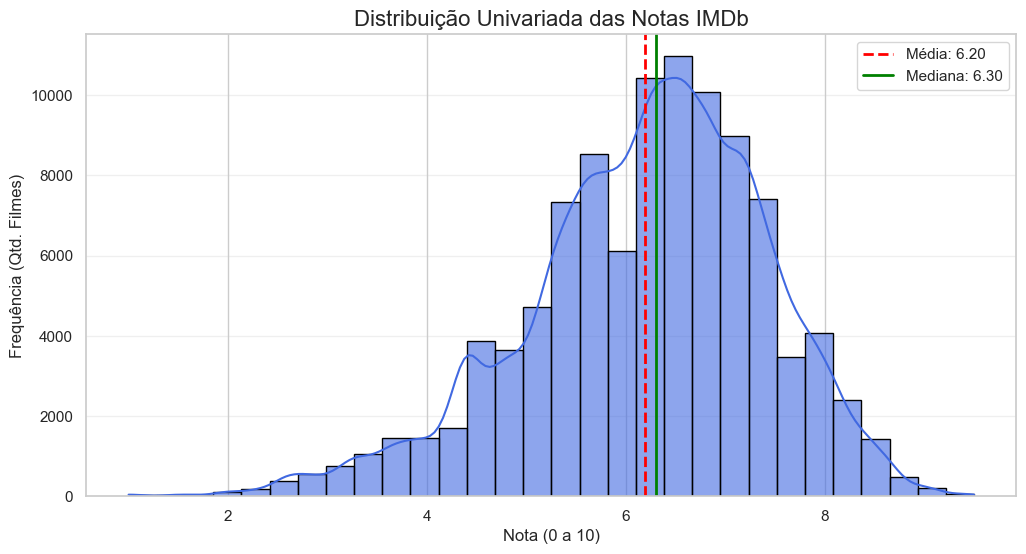

In [52]:
# --- Configuração de Caminhos ---
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

# 1. Carrega o DataFrame (com verificação de segurança)
if not os.path.exists(output_csv_file):
    print(f"❌ Erro: Arquivo não encontrado em {output_csv_file}")
else:
    df = pd.read_csv(output_csv_file)
    # Limpeza preventiva
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # --- ANÁLISE UNIVARIADA: NOTA IMDB (A variável mais importante) ---
    # Esta variável responde diretamente às perguntas sobre qualidade do conteúdo
    
    # 2. Cálculos Estatísticos (Tendência Central e Dispersão)
    # Isso cobre o requisito "medidas de tendência central e dispersão"
    coluna_alvo = 'imdb_rating_concatenada'
    stats = df[coluna_alvo].describe()
    
    media = stats['mean']
    mediana = stats['50%']
    desvio_padrao = stats['std']
    
    # Identificação de Outliers (Valores Atípicos) via IQR
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers_count = df[(df[coluna_alvo] < limite_inferior) | (df[coluna_alvo] > limite_superior)].shape[0]

    print("=== Estatísticas Descritivas (Análise Numérica) ===")
    print(f"Média: {media:.2f}")
    print(f"Mediana: {mediana:.2f}")
    print(f"Desvio Padrão: {desvio_padrao:.2f}")
    print(f"Intervalo Interquartil (IQR): {IQR:.2f}")
    print(f"Outliers detectados (fora de {limite_inferior:.1f} e {limite_superior:.1f}): {outliers_count} registros")

    # 3. Geração do Gráfico Único (Distribuição e Padrões)
    plt.figure(figsize=(12, 6))
    
    # Histograma com KDE (Linha de densidade suave)
    sns.histplot(data=df, x=coluna_alvo, kde=True, bins=30, color='royalblue', edgecolor='black', alpha=0.6)
    
    # Adicionando linhas de referência (Tendência Central)
    plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Média: {media:.2f}')
    plt.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
    
    # Customização
    plt.title('Distribuição Univariada das Notas IMDb', fontsize=16)
    plt.xlabel('Nota (0 a 10)', fontsize=12)
    plt.ylabel('Frequência (Qtd. Filmes)', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Exibe o gráfico na saída (sem salvar arquivo)
    plt.show()

### Análise Bivariada

Dataset carregado para Análise Bivariada.

=== Comparação entre Grupos (Nota Média por Faixa Etária) ===
Faixa 1 (Livre): Nota Média 6.37
Faixa 2 (PG): Nota Média 6.33
Faixa 3 (7+): Nota Média 6.48
Faixa 4 (13+): Nota Média 6.16
Faixa 5 (14+): Nota Média 6.20
Faixa 6 (18+): Nota Média 6.12

=== Matriz de Correlação (Valores) ===
imdb_rating_concatenada    1.000000
run_time_minutes           0.136919
release_year              -0.039726
rating_target             -0.069874
Name: imdb_rating_concatenada, dtype: float64


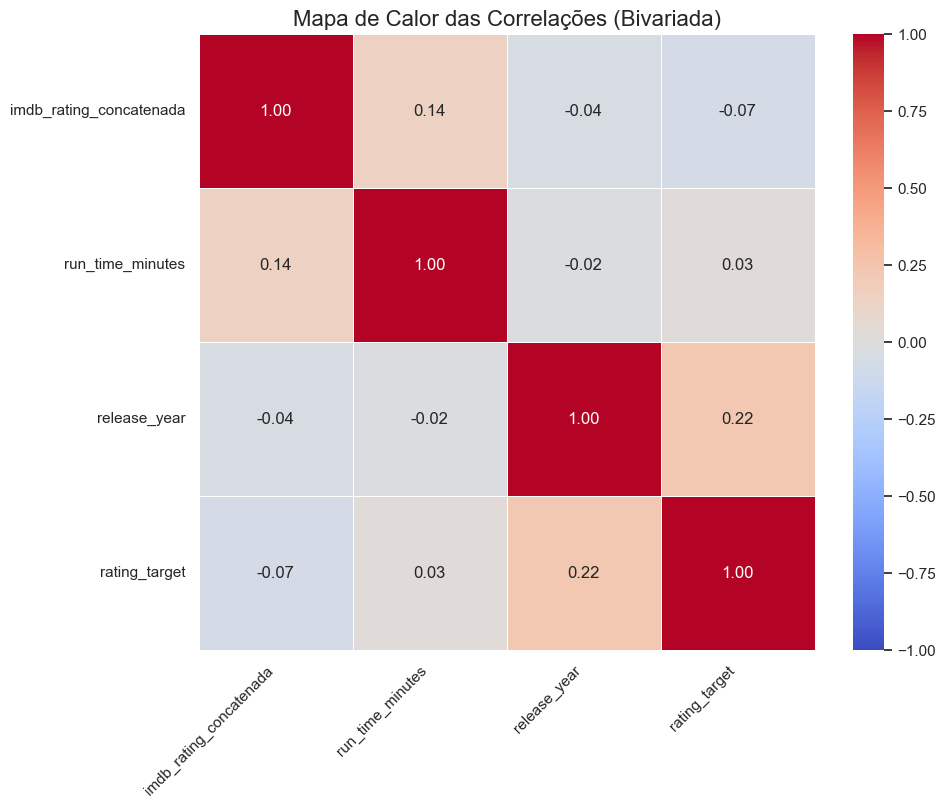


💡 Interpretação:
- Valores próximos de 1: Forte correlação positiva (quando um sobe, o outro sobe).
- Valores próximos de -1: Forte correlação negativa (quando um sobe, o outro desce).
- Valores próximos de 0: Não há correlação linear evidente.


In [53]:
# --- Configuração de Caminhos ---
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

# 1. Carrega o DataFrame
if not os.path.exists(output_csv_file):
    print(f"❌ Erro: Arquivo não encontrado em {output_csv_file}")
else:
    df = pd.read_csv(output_csv_file)
    # Limpeza preventiva
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    print(f"Dataset carregado para Análise Bivariada.")

    # --- SELEÇÃO DE VARIÁVEIS ---
    # Vamos cruzar variáveis numéricas e ordinais importantes
    # imdb_rating_concatenada: A nota (Target)
    # run_time_minutes: Duração
    # release_year: Ano (para ver se filmes mais novos têm notas maiores/menores)
    # rating_target: Classificação etária (1 a 6) - Transformada em número anteriormente
    
    cols_interesse = ['imdb_rating_concatenada', 'run_time_minutes', 'release_year', 'rating_target']
    
    # Filtrar apenas as colunas que existem no DF (caso alguma tenha sido removida)
    cols_existentes = [c for c in cols_interesse if c in df.columns]
    
    if len(cols_existentes) < 2:
        print("⚠️ Colunas insuficientes para correlação.")
    else:
        # 2. COMPARAÇÃO ENTRE GRUPOS (Numérica)
        # Responde: "A classificação indicativa influencia a nota?"
        if 'rating_target' in df.columns:
            print("\n=== Comparação entre Grupos (Nota Média por Faixa Etária) ===")
            # Agrupa pelo rating e tira a média da nota IMDb
            grupo_rating = df.groupby('rating_target')['imdb_rating_concatenada'].mean().sort_index()
            
            mapa_labels = {
                1: '1 (Livre)', 2: '2 (PG)', 3: '3 (7+)', 
                4: '4 (13+)', 5: '5 (14+)', 6: '6 (18+)'
            }
            
            for rating, media in grupo_rating.items():
                label = mapa_labels.get(rating, str(rating))
                print(f"Faixa {label}: Nota Média {media:.2f}")

        # 3. CÁLCULO DE CORRELAÇÕES
        # Responde: "Existe relação linear entre duração e nota? Ano e nota?"
        corr_matrix = df[cols_existentes].corr()

        print("\n=== Matriz de Correlação (Valores) ===")
        print(corr_matrix['imdb_rating_concatenada'].sort_values(ascending=False))

        # 4. VISUALIZAÇÃO (Heatmap)
        # O Heatmap é ideal para identificar padrões em matrizes
        plt.figure(figsize=(10, 8))
        
        # Gerando o mapa de calor
        # annot=True mostra os números nos quadrados
        # cmap='coolwarm' usa azul para correlação negativa e vermelho para positiva
        # vmin=-1, vmax=1 garante que a escala de cores vá de -1 a 1
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=.5)
        
        plt.title('Mapa de Calor das Correlações (Bivariada)', fontsize=16)
        plt.xticks(rotation=45, ha='right') # Rotaciona os labels x para ler melhor
        plt.yticks(rotation=0)
        
        # Exibe o gráfico na saída
        plt.show()
        
        print("\n💡 Interpretação:")
        print("- Valores próximos de 1: Forte correlação positiva (quando um sobe, o outro sobe).")
        print("- Valores próximos de -1: Forte correlação negativa (quando um sobe, o outro desce).")
        print("- Valores próximos de 0: Não há correlação linear evidente.")

### Análise Multivariada

Dataset carregado para Análise Multivariada.
Registros utilizados na análise: 101939


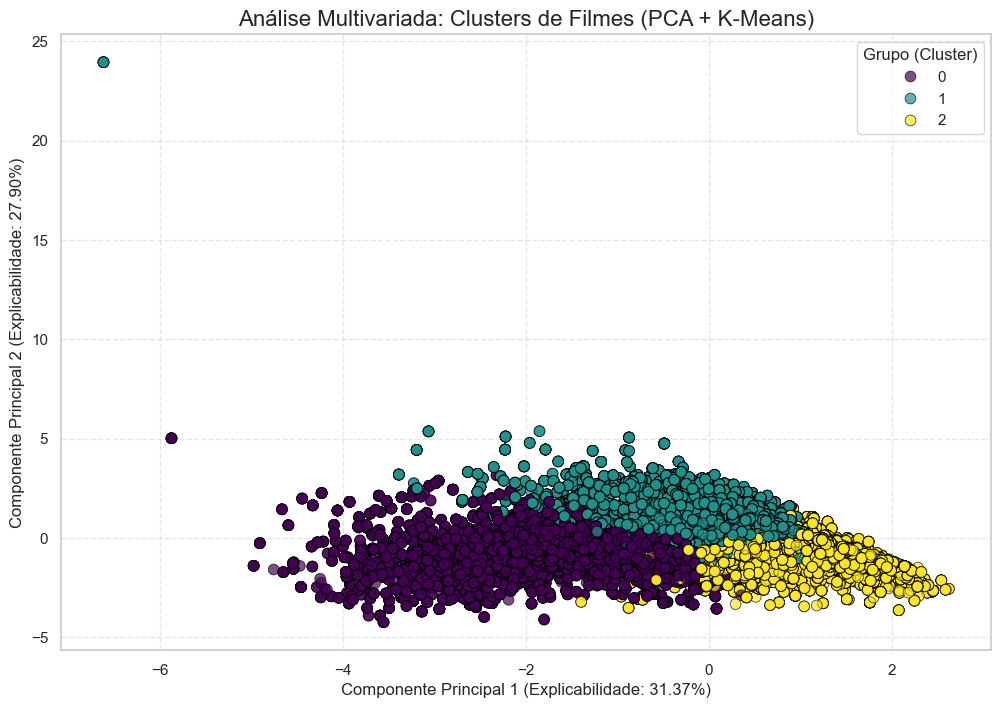


=== Interpretação dos Agrupamentos (Perfil Médio) ===
         imdb_rating_concatenada  run_time_minutes  release_year  \
Cluster                                                            
0                       6.396637         96.765144   1998.595618   
1                       6.959003        107.647258   2013.421054   
2                       4.937028         94.147568   2014.952847   

         rating_target  
Cluster                 
0             2.192202  
1             5.334857  
2             5.330580  

💡 Dica de Leitura:
- Observe a tabela acima para dar 'nomes' aos clusters.
- Exemplo: O Cluster 0 pode ter 'Notas Altas e Antigos', enquanto o Cluster 1 pode ser 'Filmes Longos'.
- O gráfico mostra visualmente como esses grupos se separam no espaço matemático.


In [56]:
# --- Configuração de Caminhos ---
imdb_data_dir = '../data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

# 1. Carrega o DataFrame
if not os.path.exists(output_csv_file):
    print(f"❌ Erro: Arquivo não encontrado em {output_csv_file}")
else:
    df = pd.read_csv(output_csv_file)
    # Limpeza preventiva
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    print(f"Dataset carregado para Análise Multivariada.")

    # --- SELEÇÃO DE FEATURES (VARIÁVEIS) ---
    # Para a análise multivariada, precisamos de variáveis numéricas
    features = ['imdb_rating_concatenada', 'run_time_minutes', 'release_year']
    
    # Adiciona rating_target se existir (enriquece a análise)
    if 'rating_target' in df.columns:
        features.append('rating_target')
    
    # Filtra apenas linhas que tenham todas essas informações preenchidas
    df_multi = df[features].dropna()
    
    print(f"Registros utilizados na análise: {len(df_multi)}")

    # 2. PADRONIZAÇÃO DOS DADOS (StandardScaler)
    # Essencial para PCA e K-Means, pois a 'Duração' (ex: 120) é muito maior que a 'Nota' (ex: 8.0).
    # Isso coloca tudo na mesma escala.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_multi)

    # 3. CLUSTERING (K-Means) - Análise de Agrupamento
    # Vamos tentar dividir os filmes em 3 grupos (clusters) baseados em suas similaridades
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Adiciona o cluster ao dataframe para usarmos na cor do gráfico
    df_multi['Cluster'] = clusters

    # 4. REDUÇÃO DE DIMENSIONALIDADE (PCA)
    # Reduzimos de 3 ou 4 dimensões para apenas 2 componentes principais (PC1 e PC2)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    
    # Cria um DataFrame temporário com as coordenadas PCA
    df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    df_pca['Cluster'] = clusters

    # 5. VISUALIZAÇÃO (Scatter Plot com Clusters)
    plt.figure(figsize=(12, 8))
    
    # Scatterplot: PC1 no eixo X, PC2 no eixo Y, cor definida pelo Cluster
    sns.scatterplot(
        x='PC1', y='PC2', 
        hue='Cluster', 
        palette='viridis', 
        data=df_pca, 
        s=60, alpha=0.7, edgecolor='black'
    )
    
    plt.title('Análise Multivariada: Clusters de Filmes (PCA + K-Means)', fontsize=16)
    plt.xlabel(f'Componente Principal 1 (Explicabilidade: {pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
    plt.ylabel(f'Componente Principal 2 (Explicabilidade: {pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Grupo (Cluster)')
    
    plt.show()

    # --- INTERPRETAÇÃO DOS GRUPOS ---
    # Vamos entender o que cada Cluster representa calculando a média das variáveis originais
    print("\n=== Interpretação dos Agrupamentos (Perfil Médio) ===")
    perfil_medio = df_multi.groupby('Cluster').mean()
    print(perfil_medio)
    
    print("\n💡 Dica de Leitura:")
    print("- Observe a tabela acima para dar 'nomes' aos clusters.")
    print("- Exemplo: O Cluster 0 pode ter 'Notas Altas e Antigos', enquanto o Cluster 1 pode ser 'Filmes Longos'.")
    print("- O gráfico mostra visualmente como esses grupos se separam no espaço matemático.")

### Testes de Hipótese

• H1: Filmes de terror costumam ter uma nota menor que a média

--- Testando H1: Filmes de Terror têm notas menores? ---
Qtd. Filmes Terror: 7834 | Média: 5.21
Qtd. Outros Gêneros: 94105 | Média: 6.28

Resultado do Teste T: Estatística=-72.65, P-valor=0.0000e+00
✅ CONCLUSÃO: Hipótese Confirmada! A diferença é estatisticamente relevante.


E:\Users\kauma\AppData\Local\Temp\ipykernel_22688\3870120515.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Categoria', y='Nota', data=plot_data, palette=['#FF5555', '#AAAAAA'])


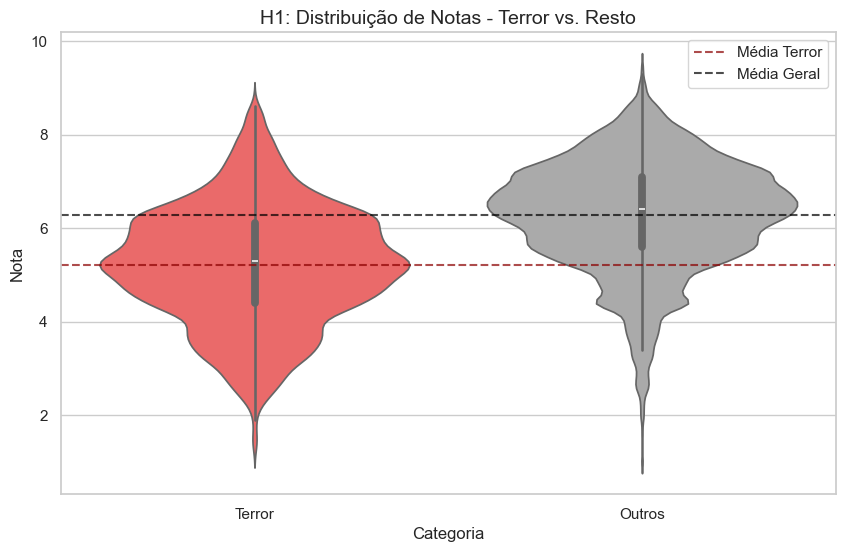

In [58]:
# --- Configuração ---
imdb_data_dir = '../data'
csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

if not os.path.exists(csv_file):
    print("Arquivo não encontrado.")
else:
    df = pd.read_csv(csv_file)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    print("--- Testando H1: Filmes de Terror têm notas menores? ---")

    # 1. Preparação dos Grupos
    # Grupo A: Filmes de Terror
    group_horror = df[df['Genre_Horror'] == 1]['imdb_rating_concatenada']
    
    # Grupo B: Resto do Mundo (Não Terror)
    group_others = df[df['Genre_Horror'] == 0]['imdb_rating_concatenada']

    print(f"Qtd. Filmes Terror: {len(group_horror)} | Média: {group_horror.mean():.2f}")
    print(f"Qtd. Outros Gêneros: {len(group_others)} | Média: {group_others.mean():.2f}")

    # 2. Teste Estatístico (T-Test de Amostras Independentes)
    # Verifica se a diferença entre as médias é estatisticamente significativa
    t_stat, p_val = stats.ttest_ind(group_horror, group_others, equal_var=False)

    print(f"\nResultado do Teste T: Estatística={t_stat:.2f}, P-valor={p_val:.4e}")
    if p_val < 0.05 and t_stat < 0:
        print("✅ CONCLUSÃO: Hipótese Confirmada! A diferença é estatisticamente relevante.")
    else:
        print("❌ CONCLUSÃO: Hipótese Rejeitada. Não há diferença significativa negativa.")

    # 3. Visualização (Violin Plot)
    plt.figure(figsize=(10, 6))
    
    # Cria um DF temporário apenas para o gráfico
    plot_data = pd.DataFrame({
        'Nota': pd.concat([group_horror, group_others]),
        'Categoria': ['Terror'] * len(group_horror) + ['Outros'] * len(group_others)
    })

    sns.violinplot(x='Categoria', y='Nota', data=plot_data, palette=['#FF5555', '#AAAAAA'])
    
    # Linhas de média
    plt.axhline(group_horror.mean(), color='darkred', linestyle='--', alpha=0.7, label='Média Terror')
    plt.axhline(group_others.mean(), color='black', linestyle='--', alpha=0.7, label='Média Geral')
    
    plt.title('H1: Distribuição de Notas - Terror vs. Resto', fontsize=14)
    plt.legend()
    plt.show()

• H2: Filmes no Disney Plus chegam mais rápido ao streaming

--- Testando H2: Disney+ é mais rápido (Janela de Lançamento menor)? ---
Média de Atraso Disney+: 14.02 anos
Média de Atraso Concorrência: 6.22 anos

Resultado Mann-Whitney: P-valor=1.0000e+00
❌ CONCLUSÃO: Hipótese Rejeitada.


E:\Users\kauma\AppData\Local\Temp\ipykernel_22688\1235196325.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Plataforma', y='Atraso (Anos)', data=viz_df, palette=['#113CCF', '#999999'], errorbar=('ci', 95))


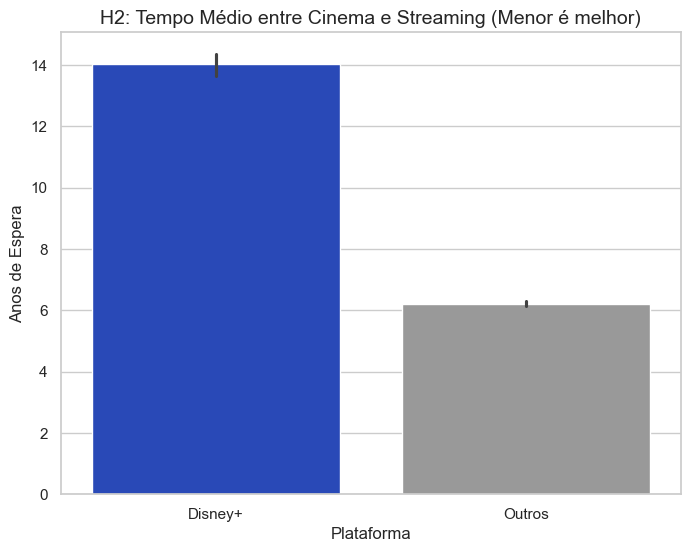

In [59]:
# --- Configuração ---
imdb_data_dir = '../data'
csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

if not os.path.exists(csv_file):
    print("Arquivo não encontrado.")
else:
    df = pd.read_csv(csv_file)
    
    print("--- Testando H2: Disney+ é mais rápido (Janela de Lançamento menor)? ---")

    # 1. Engenharia de Atributos (Calcular o Delay)
    # Convertemos o Timestamp de volta para Data para extrair o ano
    # Assumindo que date_added está em segundos (conforme passo anterior)
    df['date_added_dt'] = pd.to_datetime(df['date_added'], unit='s', errors='coerce')
    df['year_added'] = df['date_added_dt'].dt.year
    
    # Cálculo do Delay (Atraso em anos)
    df['launch_delay'] = df['year_added'] - df['release_year']
    
    # Filtro: Remover dados inconsistentes (Delay negativo ou absurdo > 50 anos)
    df_clean = df[(df['launch_delay'] >= 0) & (df['launch_delay'] < 50)].copy()

    # 2. Definição dos Grupos
    # Nota: Precisamos usar aspas se tiver caracteres especiais, mas no pandas usamos a sintaxe de coluna direta
    disney_data = df_clean[df_clean['Streaming_Disney+'] == 1]['launch_delay']
    others_data = df_clean[df_clean['Streaming_Disney+'] == 0]['launch_delay']

    print(f"Média de Atraso Disney+: {disney_data.mean():.2f} anos")
    print(f"Média de Atraso Concorrência: {others_data.mean():.2f} anos")

    # 3. Teste Estatístico (Mann-Whitney U)
    # Usamos Mann-Whitney em vez de T-test pois 'anos' não segue distribuição normal perfeita
    u_stat, p_val = stats.mannwhitneyu(disney_data, others_data, alternative='less')

    print(f"\nResultado Mann-Whitney: P-valor={p_val:.4e}")
    if p_val < 0.05:
        print("✅ CONCLUSÃO: Hipótese Confirmada! Disney+ adiciona filmes significativamente mais rápido.")
    else:
        print("❌ CONCLUSÃO: Hipótese Rejeitada.")

    # 4. Visualização (Barplot com Intervalo de Confiança)
    plt.figure(figsize=(8, 6))
    
    # Monta DF para o Seaborn
    viz_df = pd.DataFrame({
        'Atraso (Anos)': pd.concat([disney_data, others_data]),
        'Plataforma': ['Disney+'] * len(disney_data) + ['Outros'] * len(others_data)
    })
    
    sns.barplot(x='Plataforma', y='Atraso (Anos)', data=viz_df, palette=['#113CCF', '#999999'], errorbar=('ci', 95))
    
    plt.title('H2: Tempo Médio entre Cinema e Streaming (Menor é melhor)', fontsize=14)
    plt.ylabel('Anos de Espera')
    plt.show()

• H3: Atores dedicados ao gênero de terror participam de menos produções

--- Testando H3: Atores de Terror trabalham menos (Nicho)? ---
Atores analisados (mínimo 3 filmes): 7061
               cast  total_producoes  terror_ratio
39              Jr.                4      0.000000
92          50 Cent                6      0.000000
99   A. V. M. Rajan                6      0.000000
101      A.D. Miles                3      0.000000
103       A.J. Cook                3      0.666667

Correlação de Pearson: -0.0662 | P-valor: 2.5192e-08
✅ CONCLUSÃO: Hipótese Confirmada! Quanto mais focado em terror, menor o volume total de obras.


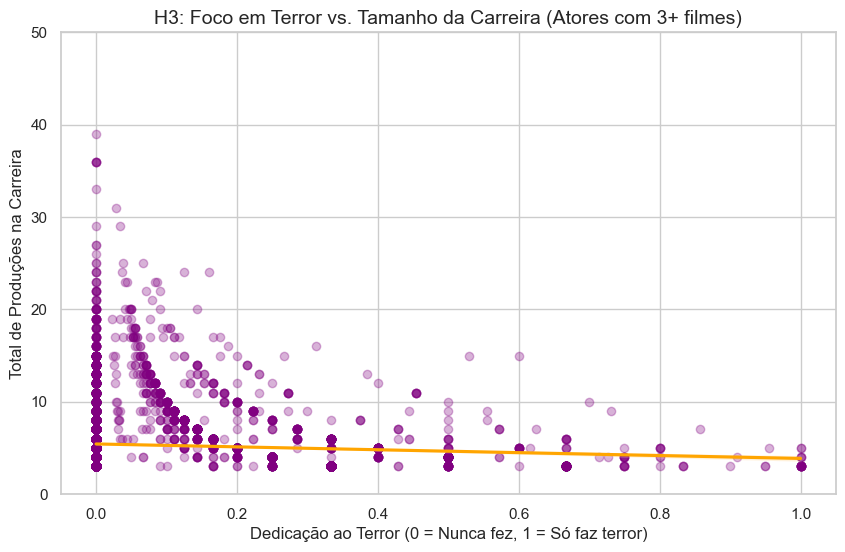

In [60]:
# --- Configuração ---
imdb_data_dir = '../data'
csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

if not os.path.exists(csv_file):
    print("Arquivo não encontrado.")
else:
    df = pd.read_csv(csv_file)
    
    print("--- Testando H3: Atores de Terror trabalham menos (Nicho)? ---")

    # 1. Preparação dos Dados (Agrupar por Ator)
    # Como o DF está explodido, cada linha é filme-ator. Vamos reagrupar.
    # Precisamos filtrar 'Unknown Cast'
    df_actors = df[df['cast'] != 'Unknown Cast'].copy()
    
    # Se você já calculou 'Cast_Ratio_Genre_Horror' e 'show_id', podemos usar direto.
    # Mas para garantir precisão, vamos recalcular agregando:
    actor_stats = df_actors.groupby('cast').agg(
        total_producoes=('show_id', 'nunique'),
        terror_ratio=('Genre_Horror', 'mean') # Média de 0s e 1s dá a % de terror
    ).reset_index()

    # Filtro: Considerar apenas atores com carreira mínima (ex: > 3 filmes) para evitar ruído
    actor_stats = actor_stats[actor_stats['total_producoes'] >= 3]

    print(f"Atores analisados (mínimo 3 filmes): {len(actor_stats)}")
    print(actor_stats.head())

    # 2. Teste Estatístico (Correlação de Pearson)
    # Queremos ver se há correlação negativa entre 'terror_ratio' e 'total_producoes'
    corr, p_val = stats.pearsonr(actor_stats['terror_ratio'], actor_stats['total_producoes'])

    print(f"\nCorrelação de Pearson: {corr:.4f} | P-valor: {p_val:.4e}")
    
    if p_val < 0.05 and corr < 0:
        print("✅ CONCLUSÃO: Hipótese Confirmada! Quanto mais focado em terror, menor o volume total de obras.")
    elif p_val < 0.05 and corr > 0:
        print("❌ CONCLUSÃO: Hipótese Invertida! Atores de terror trabalham MAIS.")
    else:
        print("❌ CONCLUSÃO: Hipótese Rejeitada. Não há correlação clara.")

    # 3. Visualização (Regplot - Regressão Linear)
    plt.figure(figsize=(10, 6))
    
    sns.regplot(
        x='terror_ratio', 
        y='total_producoes', 
        data=actor_stats, 
        scatter_kws={'alpha': 0.3, 'color': 'purple'}, 
        line_kws={'color': 'orange'}
    )
    
    plt.title('H3: Foco em Terror vs. Tamanho da Carreira (Atores com 3+ filmes)', fontsize=14)
    plt.xlabel('Dedicação ao Terror (0 = Nunca fez, 1 = Só faz terror)')
    plt.ylabel('Total de Produções na Carreira')
    plt.ylim(0, 50) # Limitando o eixo Y para visualizar melhor a massa de dados (remove outliers extremos visualmente)
    plt.show()